# Figures for the AGU presentation

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-talk')

In [3]:
def extract_lines(name):
    """Get data <name>."""
    inp = xr.load_dataset(name, engine='h5netcdf')
    out = np.stack([
        inp.line_1[::2]+1j*inp.line_1[1::2],
        inp.line_2[::2]+1j*inp.line_2[1::2],
        inp.line_3[::2]+1j*inp.line_3[1::2],
    ]).T
    return out

def get_pos_neg(resp, off, min_off):
    """Separate positive and negative values, enforce min_off."""
    resp_pos = np.array([x if x > 0 else np.nan for x in resp])
    resp_neg = np.array([-x if x < 0 else np.nan for x in resp])

    resp_pos[off < min_offset] = np.nan
    resp_neg[off < min_offset] = np.nan

    return resp_pos, resp_neg

In [4]:
ds = xr.load_dataset('../../model-block/block_model_and_survey.nc', engine='h5netcdf')
rec_x = ds.x[::2].data
rec_y = ds.attrs['rec_y']

In [5]:
data = {
    'emg3d': 'emg3d',
    'custEM': 'custEM_p2',
    'PETGEM': 'petgem',
    'SimPEG': 'simpeg',
}

# Load all data
for key, value in data.items():
    data[key] = extract_lines(f"../../model-block/results/block_{value}.nc")
    
# Compute NRMSD (%)
case_names = ['emg3d-custEM', 'emg3d-PETGEM', 'emg3d-SimPEG',
              'custEM-PETGEM', 'custEM-SimPEG', 'PETGEM-SimPEG']
nrmsd = {}
for name in case_names:
    name1, name2 = name.split('-')
    data1 = data[name1]
    data2 = data[name2]
    
    nrmsd[name] = {}
    for case in ['real', 'imag', 'abs']:
        fct = getattr(np, case)
        nrmsd[name][case] = 200*abs(fct(data1) - fct(data2)) / (abs(fct(data1)) + abs(fct(data2)))

## Comparison Plots

In [6]:
# We plot data at offsets < min_offset
min_offset = 500

<ipython-input-7-a6da02e560ba>:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


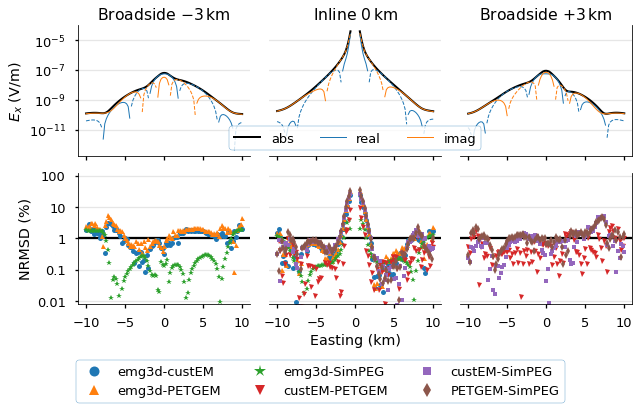

In [7]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(9, 5.6), sharey='row', sharex=True)

# # (A) Plot semi-analytical responses # #
c = ['k', 'C0', 'C1']
m = ['', 'o', 'v']
#ms = [0, 5, 3]
lw = [2, 1, 1]
        
# Plot over -3, 0, 3
for iy, ax in enumerate([ax1, ax2, ax3]):
    
    # Get offset
    off = np.sqrt(rec_x**2 + rec_y[iy]**2)
    
    # Title
    ax.set_title(['Broadside $-3\,$km', 'Inline $0\,$km', 'Broadside $+3\,$km'][iy])
    
    # Get positive and negative values
    for i, case in enumerate(['abs', 'real', 'imag']):
        fct = getattr(np, case)
        resp_pos, resp_neg = get_pos_neg(fct(data['emg3d'][:, iy]), off, min_offset)

        # Plot them
        popts = {'c': c[i], 'lw': lw[i]}
        ax.plot(rec_x/1e3, resp_pos, '-', **popts, label=case)
        ax.plot(rec_x/1e3, resp_neg, '--', **popts)

    # Axis labeling, scaling, etc
    ax.set_yscale('log')
    ax.grid(axis='y', c='0.9')
    ax.set_yticks([1e-5, 1e-7, 1e-9, 1e-11])
    if iy == 0:
        ax.set_ylabel("$E_x$ (V/m)")
    elif iy == 1:
        ax.yaxis.set_ticks_position("none")
    else:
        ax.yaxis.set_ticks_position("none")
fig1ylim = ax.get_ylim()

# # (B) Plot NRMSD # #

# Markers for scatter plots
marker = ['o', '^', '*', 'v', 's', 'd']
ms = [5, 5, 6, 5, 4, 5]

# Plot over -3, 0, 3
for iy, ax in enumerate([ax4, ax5, ax6]):
    
    # Get offset
    off = np.sqrt(rec_x**2 + rec_y[iy]**2)
        
    # Get positive and negative values
    for i, name in enumerate(nrmsd.keys()):
        
        p_nrmsd = nrmsd[name]['abs'][:, iy]
        p_nrmsd[off < min_offset] = np.nan
        if iy == 0 and i < 3 or iy == 1 or iy == 2 and i >2:
            ax.plot(rec_x/1e3, p_nrmsd, f"C{i}", lw=0, marker=marker[i], ms=ms[i], label=name)

    # Axis labeling, scaling, etc
    ax.set_yscale('log')
    ax.set_xticks([-10, -5, 0, 5, 10])
    ax.grid(axis='y', c='0.9')
    ax.set_ylim([8e-3, 120])
    ax.set_yticks([0.01, 0.1, 1, 10, 100])
    ax.set_yticklabels(['0.01', '0.1', '1', '10', '100'])
    ax.axhline(1, c='k', zorder=1.9)
    if iy == 0:
        ax.set_ylabel('NRMSD (%)')
    elif iy == 1:
        ax.set_xlabel('Easting (km)')
        ax.yaxis.set_ticks_position("none")
    else:
        ax.yaxis.set_ticks_position("none")


# Switch off spines
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.spines['top'].set_visible(False)
for ax in [ax1, ax2, ax4, ax5]:
    ax.spines['right'].set_visible(False)
for ax in [ax2, ax3, ax5, ax6]:
    ax.spines['left'].set_visible(False)
    
plt.tight_layout(rect=[0, 0.1, 1, 1])

ax2.legend(loc='lower center', edgecolor='C0', ncol=3)
ax2.set_zorder(1000)

ax5.legend(bbox_to_anchor=(0.5, -0.01), edgecolor='C0', bbox_transform=fig.transFigure,
           loc='lower center', borderaxespad=0., ncol=3, markerscale=2)  

fig.savefig(f'../figures/results-block.pdf', bbox_inches='tight')
fig.show()

<ipython-input-8-e39754ef5b0a>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


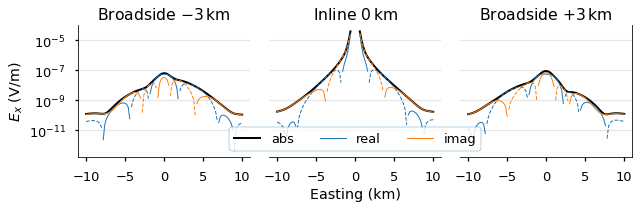

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), sharey='row', sharex=True)

# Plot over -3, 0, 3
for iy, ax in enumerate([ax1, ax2, ax3]):
    
    # Get offset
    off = np.sqrt(rec_x**2 + rec_y[iy]**2)
    
    # Title
    ax.set_title(['Broadside $-3\,$km', 'Inline $0\,$km', 'Broadside $+3\,$km'][iy])
    ls = ['-', '--', '-.', ':']
    # Get positive and negative values
    for i, case in enumerate(['abs', 'real', 'imag']):
        fct = getattr(np, case)
        resp_pos, resp_neg = get_pos_neg(fct(data['emg3d'][:, iy]), off, min_offset)

        # Plot them
        popts = {'c': c[i], 'lw': lw[i]}
        ax.plot(rec_x/1e3, resp_pos, '-', **popts, label=case)
        ax.plot(rec_x/1e3, resp_neg, '--', **popts)

    # Axis labeling, scaling, etc
    ax.set_yscale('log')
    ax.set_xticks([-10, -5, 0, 5, 10])
    ax.set_yticks([1e-5, 1e-7, 1e-9, 1e-11])
    ax.set_ylim(fig1ylim)
    ax.grid(axis='y', c='0.9')
    if iy == 0:
        ax.set_ylabel("$E_x$ (V/m)")
    elif iy == 1:
        ax.yaxis.set_ticks_position("none")
        ax.set_xlabel('Easting (km)')
    else:
        ax.yaxis.set_ticks_position("none")

# Switch off spines
for ax in [ax1, ax2, ax3]:
    ax.spines['top'].set_visible(False)
for ax in [ax1, ax2]:
    ax.spines['right'].set_visible(False)
for ax in [ax2, ax3]:
    ax.spines['left'].set_visible(False)
    
plt.tight_layout(rect=[0, 0, 1, 1])

ax2.legend(ncol=4, loc='lower center', edgecolor='C0')
ax2.set_zorder(100)


fig.savefig(f'../figures/results-block-all-2.pdf', bbox_inches='tight')

fig.show()

In [9]:
import scooby
scooby.Report()

--------------------------------------------------------------------------------
  Date: Fri Nov 20 16:14:31 2020 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49)
  [GCC 7.5.0]

             numpy : 1.19.1
             scipy : 1.5.2
           IPython : 7.18.1
        matplotlib : 3.3.1
            scooby : 0.5.6

  Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------